<a href="https://colab.research.google.com/github/agi2019/ppi-gci/blob/main/tutorials/04%20-%20structural_bottlenecks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>Structural bottlenecks</center>

Prepared by Omar A. Guerrero (oguerrero@turing.ac.uk, <a href="https://twitter.com/guerrero_oa">@guerrero_oa</a>)

The previous tutorial explained how to simulate a budgetary intervention. The results suggest that, for this example, the indicators respond modestly to linear increments in government expenditure. In this tutorial, I will explain how to expand on the idea of expenditure sensitivity in order to quantify structural bottlenecks, a concept that is often discussed in the development economics and SDG literature, but that is rarely formalised. In addition, I will show you how to perform a larger set of Monte Carlo simulations while distributing their work load across multiple cores or processors.

## Importing Python libraries to manipulate and visualise data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#scenario = '_scenario1'
#scenario = '_scenario2'
scenario = '_scenario3'

## Importing PPI functions

In [3]:
import requests
url = 'https://raw.githubusercontent.com/agi2019/ppi-gci/main/source_code/policy_priority_inference.py'
r = requests.get(url)
with open('policy_priority_inference.py', 'w') as f:
    f.write(r.text)
import policy_priority_inference as ppi

## Load data

In [4]:
# INDICATORS
df_indis = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_indicators.csv')
N = len(df_indis) # number of indicators
I0 = df_indis.I0.values # initial values
R = df_indis.instrumental # instrumental indicators
qm = df_indis.qm.values # quality of monitoring
rl = df_indis.rl.values # quality of the rule of law
indis_index = dict([(code, i) for i, code in enumerate(df_indis.seriesCode)]) # used to build the network matrix
Imax = df_indis.maxVals.values
Imin = df_indis.minVals.values
#goals = np.random.rand(N)*(Imax - I0) + I0
goals = Imax

# PARAMETERS
df_params = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/parameters.csv')
alphas = df_params.alpha.values
alphas_prime = df_params.alpha_prime.values
betas = df_params.beta.values

# NETWORK
df_net = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_network.csv')
A = np.zeros((N, N)) # adjacency matrix
for index, row in df_net.iterrows():
    i = indis_index[row.origin]
    j = indis_index[row.destination]
    w = row.weight
    A[i,j] = w

# DISBURSEMENT SCHEDULE (make sure that the disbursement schedule is consistent with T, otherwise PPI will simulate the T of the calibration)
T = 66
df_exp = pd.read_csv('C:/Users/rha005/OneDrive - CSIRO/Documents/7. CSIRO/00. Work in Progress - ON Office/Week 9-10/ppi-gci-main-indicators/tutorials/clean_data'+scenario+'/data_expenditure.csv')
Bs_retrospective = df_exp.drop(columns='seriesCode').values  # shape = (63 x tahun)

# Create a new disbursement schedule assuming that expenditure will be the same as the last period of the sample
# Bs tetap 63 x T
Bs = np.tile(Bs_retrospective[:, -1], (T, 1)).T  # shape: (63, T)

# Build B_dict: key = indeks indikator instrumental, value = [index_in_Bs]
#B_dict = {i: [i] for i in range(len(Bs)) if df_indis['instrumental'].iloc[i] == 1}
# Ambil mask indikator instrumental
instrumental_mask = df_indis['instrumental'].astype(bool).values

# Bangun B_dict hanya untuk indikator instrumental (jumlah = 56)
B_dict = {i: [i] for i in range(len(instrumental_mask)) if instrumental_mask[i]}

# Validasi
assert len(B_dict) == instrumental_mask.sum()   # Harus 56
assert max(p for v in B_dict.values() for p in v) < Bs.shape[0]  # Harus < 63

In [5]:
# 1. Ambil indeks program yang digunakan
used_programs = sorted(set(p for v in B_dict.values() for p in v))

# 2. Subset Bs hanya ke program yang digunakan
Bs_used = Bs[used_programs, :]  # shape: (56, T)

# 3. Bangun ulang B_dict agar sesuai dengan Bs_used yang sudah disubset
old2new = {old: new for new, old in enumerate(used_programs)}
B_dict_new = {k: [old2new[v[0]]] for k, v in B_dict.items()}


## Bottlenecks

In the book, we develop two definitions of structural bottlenecks:

1. Idiosyncratic bottlenecks: Those that focus on the structural constraints of a single indicator.
2. Systemic bottlenecks: Those that "clog" the development of other policy issues through indirect impacts.

In this tutorial, I will focus on the first type: <strong>idiosyncratic bottlenecks</strong>. An idiosyncratic bottleneck manifests when an indicator with a bad historical performance responds poorly to budgetary interventions. An indicator may not respond to an expenditure programme because it experiences strong structural constraints that can only be lifted through long-term structural reforms (e.g., redesigning the relevant government programmes). This type of problems cannot be solved by spending more resources as the government programmes in place are likely ill-conceived.


### The budgetary frontier

To identify an idiosyncratic bottleneck you need to think of a hypothetical budgetary intervention that would lift all financial obstacles and negative spillovers. Effectively, such scenario would mean that the probability of success of the intervened indicator is always 1. This hypothetical scenario is called the <strong>budgetary frontier</strong>, and was originally developed in https://doi.org/10.1007/s11625-022-01095-1. The idea is that, if a government operates on the budgetary frontier, and there are indicators that respond poorly, it means that they are being constrained by long-term structural factors.

To perform frontier analysis, the `run_ppi` function offers the optional parameter `frontier`. This parameter consists of a vector specifying the probability of success that one would like to exogenously impose to each indicator. Hence, for this tutorial, I will impose a value of 1 for all indicators at the same time. A more nuanced analysis may consider to only analyse one or a subset of indicators at a time.


### Parallelisation

Instead of calling the `run_ppi` function in an explicit `for` loop, I will use `run_ppi_parallel`, which allows to perform multiple Monte Carlo simulations and distribute their load across four cores or processors. This function takes the same inputs as `run_ppi` with a couple of additional ones to specify the number of simulations. First, I will run the baseline simulation and, then, the frontier one.

In [6]:
parallel_processes=4
sample_size=100 # now we increase the sample size from 100 (which was used in the previous tutorial) to 1000

# first the baseline
outputs_baseline = ppi.run_ppi_parallel(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                                        Imax=Imax, Imin=Imin, Bs=Bs_used, B_dict=B_dict_new, T=T, G=goals,
                                        parallel_processes=parallel_processes, sample_size=sample_size)

# now the frontier
# notice that Bs and B_dict will be overridden by frontier
frontier = np.ones(N)
outputs_frontier = ppi.run_ppi_parallel(I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
                                        Imax=Imax, Imin=Imin, Bs=Bs_used, B_dict=B_dict_new, T=T, G=goals, frontier=frontier,
                                        parallel_processes=parallel_processes, sample_size=sample_size)

Now we unpack the outputs and obtain the average time series of the baseline and the counterfactual.

In [7]:
tsI_sample, tsC_sample, tsF_sample, tsP_sample, tsS_sample, tsG_sample = outputs_baseline
tsI_baseline = np.mean(tsI_sample, axis=0)

tsI_sample, tsC_sample, tsF_sample, tsP_sample, tsS_sample, tsG_sample = outputs_frontier
tsI_frontier = np.mean(tsI_sample, axis=0)

Time to visualise the difference in development gaps.

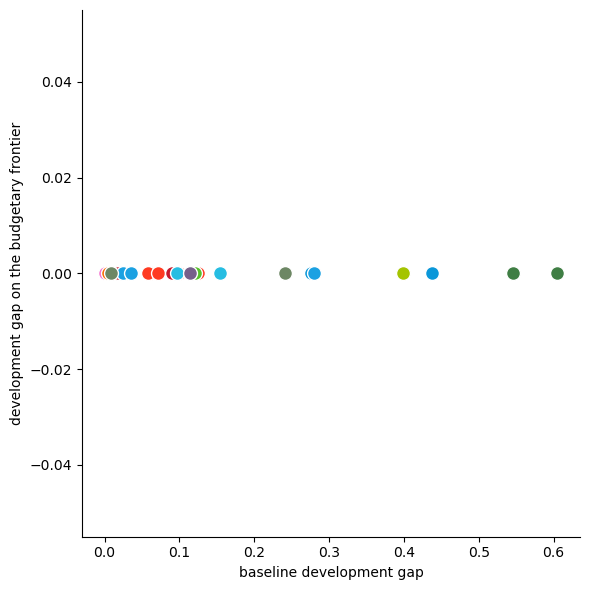

In [8]:
plt.figure(figsize=(6, 6))
for index, row in df_indis.iterrows():
    goal = goals[index]
    if goal > tsI_baseline[index,T-1]: # consider only those indicators that would not reach their goals
        plt.plot(goal-tsI_baseline[index,T-1], goal-tsI_frontier[index,T-1],
                 '.', mec='w', mfc=row.color, markersize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlabel('baseline development gap')
plt.ylabel('development gap on the budgetary frontier')
plt.tight_layout()

Now you can see that, on the frontier, many indicators would respond by closing their gaps, or even surpassing their goals (negative values in the vertical axis). Other indicators, in contrast, still show no sensitivity to the removal of financial constraints, flagging potential bottlenecks.

The next step is to identify those policy issues that are insensitive and have shown poor performance in the historical data. The latter criterion, poor performance, can be arbitrary and context specific. For this example, I establish as the threshold of bad performance an average historical level of 0.5.

Now, let me show a scatter plot that reveals the potential idiosyncratic bottlenecks. The plot shows the historical performance of each indicator against the fraction of the development gap that is closed when operating on the budgetary frontier. I colour the bottleneck area in gray.

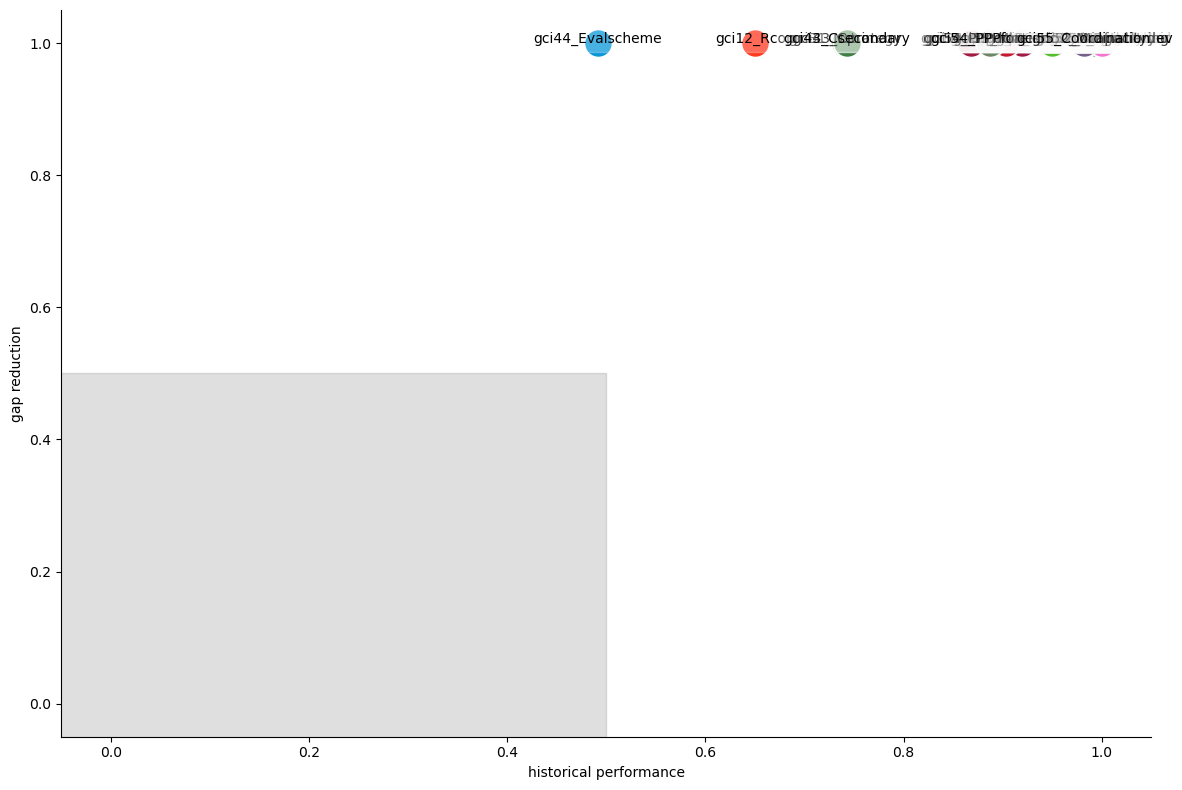

In [9]:
years = [c for c in df_indis.columns if str(c).isnumeric()]
plt.figure(figsize=(12, 8))
plt.fill_between([-.5, .5], [-.5, -.5], [.5, .5], color='grey', alpha=.25)
for index, row in df_indis.iterrows():
    goal = goals[index]
    hist_performance = np.mean(row[years])
    if goal > tsI_baseline[index,T-1]:
        gap_base = goal-tsI_baseline[index,T-1]
        gap_frontier = np.max([0, goal-tsI_frontier[index,T-1]])
        gap_reduction = (gap_base - gap_frontier)/gap_base
        plt.plot(hist_performance, gap_reduction, '.', mec='w', mfc=row.color, markersize=40)
for index, row in df_indis.iterrows():
    goal = goals[index]
    hist_performance = np.mean(row[years])
    if goal > tsI_baseline[index,T-1]:
        gap_base = goal-tsI_baseline[index,T-1]
        gap_frontier = np.max([0, goal-tsI_frontier[index,T-1]])
        gap_reduction = (gap_base - gap_frontier)/gap_base
        txt = plt.text(hist_performance, gap_reduction, row.seriesCode, color='black',
                       horizontalalignment='center')
        txt.set_bbox(dict(facecolor='white', alpha=0.25, edgecolor='white'))
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim(-.05, 1.05)
plt.ylim(-.05, 1.05)
plt.xlabel('historical performance')
plt.ylabel('gap reduction')
plt.tight_layout()

In [10]:
#Impact of each Programs to GCI Score

In [11]:
print("I0:", I0)
print("I0:", I0.shape)
print("alphas:", alphas)
print("alphas:", alphas.shape)
print("alphas_prime:", alphas_prime)
print("betas:", betas)
print("A:", A)
print("R:", R)
print("qm:", qm)
print("rl:", rl)
print("Imax:", Imax)
print("Imin:", Imin)

instr_idx = np.where(R == 1)[0]
num_instr = len(instr_idx)
Bs_test = np.zeros((num_instr, T))
Bs_test[0, -1] = 1e10  # indikator pertama
result, *_ = ppi.run_ppi(
    I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
    Imax=Imax, Imin=Imin, Bs=Bs_test, B_dict=B_dict, T=T, G=goals
)
print("Result last:", result[:, -1])



I0: [0.95294089 0.92292454 1.         0.74193595 0.74193595 0.74193595
 0.74193595 0.74193595 0.74193595 0.62287422 0.74193595 0.53110143
 1.         1.         1.         1.         1.         1.
 0.65548399 0.65548399 0.43290665 0.55366175 0.79407108 0.79407108
 0.79407108 0.79407108 0.65548399 0.65548399 0.65548399 0.44555209
 0.44555209 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.5064543  0.50645783 0.65548399 0.74193273 0.74193273
 0.74193273 0.21374141 0.55818912 0.55818912 0.74193595 0.74193595
 0.74193595 1.         0.65466378 1.         1.         0.44555209
 0.44555209 0.44555209 0.82391674]
I0: (63,)
alphas: [0.01719371 0.00362033 0.00233266 0.01091986 0.01072749 0.01469224
 0.01348644 0.00979492 0.00934501 0.01830591 0.00929409 0.01036566
 0.01670307 0.0176309  0.01646308 0.01715078 0.01690306 0.01725129
 0.01222778 0.01214318 0.01905566 0.02468576 0.00717689 0.02375365
 0.00752366 0.00718279 0.0119

In [12]:
import pandas as pd
import numpy as np

# --- 1. Baca Data Program ---
df = pd.read_csv('clean_data'+scenario+'/program_2025.csv')
df = df.dropna(subset=['seriesCode'])
df['Budget'] = df['Budget'].astype(str).str.replace(',', '').astype(float)
df['seriesCode'] = df['seriesCode'].astype(str)

print(df['Budget'].describe())


# --- 2. Ambil Masterlist Indikator, Sinkronisasi dengan Instrumental ---
# Asumsi: all_series_codes = urutan 63 indikator di model, urut!
all_series_codes = df_indis["seriesCode"].tolist()   # 63 kode indikator, urut

# Instrumental indikator: hanya 57 (R==1)
instr_idx = np.where(R == 1)[0]
num_instr = len(instr_idx)
all_series_codes_instr = [all_series_codes[i] for i in instr_idx]
print('sorted(df[seriesCode].unique())',sorted(df['seriesCode'].unique()))
print('sorted(all_series_codes_instr)',sorted(all_series_codes_instr))
scode_to_idx = {scode: i for i, scode in enumerate(all_series_codes_instr)}
for scode in df['seriesCode'].unique():
    if scode not in scode_to_idx:
        print('Kode tidak match:', scode)


# --- 3. Buat Bs_used dan B_dict Hanya untuk Instrumental ---
T = 60   # atau sesuai model kamu
Bs_used = np.zeros((len(all_series_codes), T))
for i, scode in enumerate(all_series_codes):
    Bs_used[i, -1] = df[df['seriesCode'] == scode]['Budget'].sum()

Bs_used_instr = Bs_used[instr_idx, :]  # Ambil hanya baris indikator instrumental

# instr_idx = np.where(R == 1)[0] # Sudah dapat
B_dict = {int(idx): [i] for i, idx in enumerate(instr_idx)}

print("instr_idx:", instr_idx)
print("B_dict:", B_dict)
print(df['seriesCode'].value_counts())
print("Instr kode (masterlist):", all_series_codes_instr)
print("Mapping:", scode_to_idx)


# --- 4. Jalankan Simulasi Baseline ---
sample_size=30
outputs = []
for _ in range(sample_size):
    output = ppi.run_ppi(
        I0, alphas, alphas_prime, betas,
        A=A, R=R, qm=qm, rl=rl,
        Imax=Imax, Imin=Imin,
        Bs=Bs, B_dict=B_dict, G=goals, T=T_full
    )
    outputs.append(output)

tsI, *_ = zip(*outputs)
tsI_hat = np.mean(tsI, axis=0)  # (n, T_full)
# return IF akhir (last timestep) dari rata-rata simulasi
baseline_scores = tsI_hat[:, -1]


# --- 5. Loop Marginal Impact: Program ke Indikator Sendiri ---
impact_to_own_indicator = []

for idx, row in df.iterrows():
    Bs_test = np.zeros((num_instr, T))  # zeros untuk setiap simulasi program
    scode = row['seriesCode']
    budget = row['Budget']
    idx_series = scode_to_idx.get(scode, None)
    if idx_series is not None:
        Bs_test[idx_series, -1] = budget  # hanya 1 sel, indikator sendiri
        
        # --- JALANKAN SIMULASI MARGINAL IMPACT ---
        sample_size=30
        outputs = []
        for _ in range(sample_size):
            output = ppi.run_ppi(
                I0, alphas, alphas_prime, betas,
                A=A, R=R, qm=qm, rl=rl,
                Imax=Imax, Imin=Imin,
                Bs=Bs, B_dict=B_dict, G=goals, T=T_full
            )
            outputs.append(output)

        tsI, *_ = zip(*outputs)
        tsI_hat = np.mean(tsI, axis=0)  # (n, T_full)
        indicator_scores = tsI_hat[:, -1]
        baseline = baseline_scores[idx_series]
        print(f"[{idx}] {scode}: Baseline = {baseline}, Marginal = {indicator_scores[idx_series]}")
        impact = indicator_scores[idx_series] - baseline
        impact_to_own_indicator.append(impact)
    else:
        print(f"WARNING: {scode} tidak ada di masterlist!")
        impact_to_own_indicator.append(np.nan)

# --- 6. Gabungkan Hasil ke DataFrame dan Ekspor ---
df_result = df[['program_name', 'seriesCode', 'Budget']].copy()
df_result['impact_to_own_indicator'] = impact_to_own_indicator
df_result.to_csv('impact_per_program_to_own_indicator.csv', index=False)
print("Sudah diekspor ke impact_per_program_to_own_indicator.csv")
print(df_result.head())


count    3.510000e+02
mean     2.289289e+09
std      1.226330e+10
min      1.000000e+05
25%      7.388300e+07
50%      1.312650e+08
75%      3.025955e+08
max      1.414875e+11
Name: Budget, dtype: float64
sorted(df[seriesCode].unique()) ['gci11_Lforgery', 'gci11_Lolsafety', 'gci11_Lonline', 'gci12_RAuditre', 'gci12_Rciip', 'gci12_Rnotif', 'gci12_Rpdp', 'gci12_Rprivacy', 'gci12_Rsign', 'gci12_Rstandard', 'gci21_Nactivity', 'gci21_NatCsirt', 'gci22_Sactivity', 'gci22_Scsirt', 'gci23_FStandard', 'gci23_Fciip', 'gci31_Npriority', 'gci31_Nstrategy', 'gci32_Acapacity', 'gci32_Aciip', 'gci32_Acyber', 'gci33_Maudit', 'gci33_Mmaturity', 'gci33_Mrisk', 'gci41_AWgeneral', 'gci41_AWprivate', 'gci41_AWpublic', 'gci41_AWsociety', 'gci42_Tacreditation', 'gci42_Tprofessional', 'gci42_Tsector', 'gci43_Chigher', 'gci44_Evalscheme', 'gci44_RndAcademic', 'gci44_Rndpublic', 'gci45_Dassociation', 'gci45_Dindustry', 'gci46_Icapacitydev', 'gci46_Iindustry', 'gci51_Bcountry', 'gci51_Bregintl', 'gci52_Mcapacity

NameError: name 'T_full' is not defined

In [ ]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

# 1. Baca file dan bersihkan
df = pd.read_csv('clean_data'+scenario+'/program_2025.csv')
df = df.dropna(subset=['seriesCode'])   # pastikan tidak ada NaN
df['Budget'] = df['Budget'].astype(str).str.replace(',', '').astype(float)
df['seriesCode'] = df['seriesCode'].astype(str)

# 2. Buat master list seriesCode (bisa diambil dari Bs_used lama, atau union semua seriesCode di dataset)
# Jika kamu sudah punya urutan/daftar seriesCode dari Bs_used, pakai itu!
series_codes_from_Bs_used = sorted(set(df['seriesCode'].tolist()))  # <-- isi sesuai urutan Bs_used kamu (contoh: ['gci11_Lforgery', ...])
all_series_codes = sorted(set(df['seriesCode'].tolist()) | set(series_codes_from_Bs_used))
                          
all_series_codes = list(series_codes_from_Bs_used) if series_codes_from_Bs_used else sorted(all_series_codes)
scode_to_idx = {scode: i for i, scode in enumerate(all_series_codes)}
num_series = len(all_series_codes)
T =60  # jumlah tahun






In [ ]:
# 5. Marginal impact per program (1 program aktif, yang lain 0)
def marginal_impact_per_program(idx):
    Bs_test = np.zeros((num_indikator, T))
    row = df.iloc[idx]
    scode = row['seriesCode']
    budget = row['Budget']
    idx_series = scode_to_idx.get(scode, None)
    if idx_series is not None:
        Bs_test[idx_series, -1] = budget
    else:
        print(f"Warning: {scode} tidak ada di masterlist!")
    print("Nonzero di Bs_test:", np.nonzero(Bs_test))
    print("Value nonzero:", Bs_test[np.nonzero(Bs_test)])
    # ... lanjut run_ppi ...



In [ ]:

print("R shape:", R.shape)
print("Number of instrumental indicators:", int(np.sum(R)))
print("qm shape:", np.shape(qm))
print("qm:", qm)
print("B_dict:", np.shape(B_dict))
print("B_dict:", B_dict)
print("B_dict_new:", np.shape(B_dict_new))
print("B_dict_new:", B_dict_new)
print("Bs_Used:", np.shape(Bs_used))
print("Bs_used:", Bs_used)
print("Jumlah angka 1 di R:", int(np.sum(R)))
# 6. Simulasi baseline (semua program dijalankan bersama)
result_baseline, *_ = ppi.run_ppi(
    I0, alphas, alphas_prime, betas, A=A, R=R, qm=qm, rl=rl,
    Imax=Imax, Imin=Imin, Bs=Bs_used, B_dict=B_dict_new, T=T, G=goals
)
baseline_scores = result_baseline[:, -1]

In [ ]:
# 7. Paralel marginal impact
num_indikator = 57
indicator_scores_list = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(marginal_impact_per_program, i) for i in range(len(df))]
    for future in as_completed(futures):
        indicator_scores_list.append(future.result())
indicator_scores_list.sort(key=lambda x: x[0])
all_scores = np.vstack([x[1] for x in indicator_scores_list])


In [ ]:
# 8. Hasil ke DataFrame
all_series_codes = df_indis["seriesCode"].tolist()
print("all_scores shape:", all_scores.shape)  # Harus (351, 63)
print("len(all_series_codes):", len(all_series_codes))  # Harus 63
df_marginal = pd.DataFrame(all_scores, columns=all_series_codes)
df_marginal['program_index'] = range(len(df))
df_marginal['program_name'] = df['program_name']
df_marginal['seriesCode'] = df['seriesCode']

In [ ]:
# 9. Delta (impact) terhadap baseline
for i, scode in enumerate(all_series_codes):
    df_marginal[f'delta_{scode}'] = df_marginal[scode] - baseline_scores[i]

In [ ]:
impact_to_own_indicator = []

for idx, row in df.iterrows():
    indikator = row['seriesCode']
    delta_col = f"delta_{indikator}"
    impact = df_marginal.loc[idx, delta_col]
    impact_to_own_indicator.append(impact)

df_marginal['impact_to_own_indicator'] = impact_to_own_indicator

In [ ]:
# 10. Visualisasi Heatmap
delta_cols = [c for c in df_marginal.columns if c.startswith('delta_')]
impact_matrix = df_marginal[delta_cols].values

plt.figure(figsize=(12, max(6, len(df_marginal)//3)))
plt.imshow(impact_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Impact (Delta vs Baseline)')
plt.xticks(ticks=range(len(delta_cols)), labels=[c.replace('delta_', '') for c in delta_cols], rotation=45)
plt.yticks(ticks=range(len(df_marginal)), labels=df_marginal['program_name'])
plt.xlabel('Indicator (seriesCode)')
plt.ylabel('Program')
plt.title('Marginal Impact of Each Program on Indicators')
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Ambil hanya kolom delta (impact program thd indikator)
delta_cols = [col for col in df_marginal.columns if col.startswith('delta_')]
impact_matrix = df_marginal[delta_cols].values

plt.figure(figsize=(12, max(6, len(df_marginal)//3)))
plt.imshow(impact_matrix, aspect='auto', cmap='viridis')
plt.colorbar(label='Impact (Delta vs Baseline)')
plt.xticks(ticks=range(len(delta_cols)), labels=[c.replace('delta_', '') for c in delta_cols], rotation=45)
plt.yticks(ticks=range(len(df_marginal)), labels=df_marginal['program_name'])
plt.xlabel('Indicator (seriesCode)')
plt.ylabel('Program')
plt.title('Marginal Impact of Each Program on Indicators')
plt.tight_layout()
plt.show()

In [ ]:
# Pilih satu indikator misal 'gci11_Lforgery'
chosen_indicator = 'gci51_Bregintl'
col_name = f'delta_{chosen_indicator}'
top_programs = df_marginal[[col_name, 'program_name']].sort_values(col_name, ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top_programs['program_name'], top_programs[col_name])
plt.xlabel('Impact (Delta vs Baseline)')
plt.title(f'Top 10 Program Impact on {chosen_indicator}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))
plt.bar(df_marginal['program_name'], df_marginal[col_name])
plt.xticks(rotation=90)
plt.ylabel('Impact (Delta vs Baseline)')
plt.title(f'Impact of All Programs on {chosen_indicator}')
plt.tight_layout()
plt.show()

In [ ]:
# Kolom delta_*
delta_cols = [c for c in df_marginal.columns if c.startswith('delta_')]
# Total absolute impact per program
df_marginal['total_abs_impact'] = df_marginal[delta_cols].abs().sum(axis=1)

df_marginal['total_signed_impact'] = df_marginal[delta_cols].sum(axis=1)

# Urutkan program berdasarkan total_abs_impact
top_n = 15  # misal, tampilkan 15 program teratas
df_plot = df_marginal.sort_values('total_abs_impact', ascending=False).head(top_n)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_plot['program_name'], df_plot['total_abs_impact'])
plt.xlabel('Total Absolute Impact Across All Indicators')
plt.title(f'Top {top_n} Programs by Overall Quantitative Impact')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [ ]:
df_top = df_marginal.sort_values('total_abs_impact', ascending=False).head(100)
plt.figure(figsize=(7,7))
plt.pie(df_top['total_abs_impact'], labels=df_top['program_name'], autopct='%1.1f%%')
plt.title('Top 10 Programs: Contribution to Total Absolute Impact')
plt.show()


In [ ]:
# 1. Hitung total absolute impact untuk tiap program
delta_cols = [c for c in df_marginal.columns if c.startswith('delta_')]
df_marginal['total_abs_impact'] = df_marginal[delta_cols].abs().sum(axis=1)

# 2. Urutkan, ambil top 15 program paling “berpengaruh”
top_n = 30
df_plot = df_marginal.sort_values('total_abs_impact', ascending=False).head(top_n)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_plot['program_name'], df_plot['total_abs_impact'])
plt.xlabel('Total Absolute Impact Across All Indicators')
plt.title(f'Top {top_n} Programs by Overall Quantitative Impact')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
print(df_marginal[delta_cols].head())

In [ ]:
for idx in range(3):
    print(f"Program {df.iloc[idx]['program_name']}")
    print("Delta:", df_marginal.loc[idx, delta_cols].values)

In [ ]:
!pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# List indikator dari all_series_codes atau df_indis
indicator_options = all_series_codes  # atau df_indis["seriesCode"].tolist()

def plot_impact_for_indicator(indicator):
    delta_col = f"delta_{indicator}"
    if delta_col not in df_marginal.columns:
        print(f"Tidak ada kolom {delta_col}")
        return
    sorted_df = df_marginal.sort_values(delta_col, ascending=False)
    plt.figure(figsize=(10,6))
    plt.barh(sorted_df['program_name'], sorted_df[delta_col])
    plt.xlabel('Impact Value')
    plt.title(f'Marginal Impact of Programs on Indicator: {indicator}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Widget selector
indicator_selector = widgets.Dropdown(
    options=indicator_options,
    value=indicator_options[0],
    description='Indicator:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

widgets.interact(plot_impact_for_indicator, indicator=indicator_selector)


In [ ]:
indicator_options = all_series_codes  # atau df_indis["seriesCode"].tolist()
print("Pilih salah satu indikator berikut:")
print(indicator_options)

selected_indicator = input("Masukkan nama seriesCode indikator: ")
delta_col = f"delta_{selected_indicator}"

if delta_col in df_marginal.columns:
    sorted_df = df_marginal.sort_values(delta_col, ascending=False)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6))
    plt.barh(sorted_df['program_name'], sorted_df[delta_col])
    plt.xlabel('Impact Value')
    plt.title(f'Marginal Impact of Programs on Indicator: {selected_indicator}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"Indikator {selected_indicator} tidak ditemukan.")


In [ ]:
df_marginal.to_csv('df_marginal.csv', index=False)
print("Seluruh df_marginal sudah diekspor ke df_marginal.csv")